# Scraping from Indeed and predicting data science salaries

#### Introduction

The aim of the project is to predict whether salaries for Data Science roles, obtain from a job board, will be higher or lower than the median, based on information extracted from the location and the job title. The models also allowed us to determine which of the features where most important for the salary being higher or lower than the median. London seems to be the location mostly linked to high salaries, while small cities seem to be an important factor when the salary is low. Job titles that refer to manager, lead or engineer are also important features linked to high salaries.
The cities included in the search were the 4 main cities of the Republic of Ireland (Dublin, Galway, Cork, Limerick) and the 12 most populous cities in the UK: London, Birmingham, Glasgow, 'Liverpool', Bristol, Manchester, Sheffield, Leeds, Edinburgh, Leicester, Coventry, Bradford.
The salaries were all converted to Euro at the exchange rate of 03 September 2021: 1 GBP = 1.17 EUR (03/09/2021).
Only yearly salaries were included.
Libraries used:
-	BeautifulSoup for scraping
-	Pandas for cleaning
-	Scikit-learn for modeling
-	Matplotlib for plotting


In [ ]:
#importing required libraries
import requests
import bs4
import random
from bs4 import BeautifulSoup
from time import sleep
from random import randint
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix

#### Data collection
The data was scraped on ie.indeed.com and uk.indeed.com, using BeautifulSoup, a python library for web scraping. Functions were set up to extract location, company, job title and salary from each parsed job result. The scraper was set to iterate through each city and extract up to 500 max results per city. Through this process, over 10,000 job results were collected.


In [4]:
#Functions to extract items from job results
def extract_location_from_result(result):
    try:
        return result.find('div', class_ = 'companyLocation').text.split(",")[0]
    except:
        return None

def extract_company_from_result(result):
    try:
        return result.find('span', class_ = 'companyName').text
    except:
        try:
        #large companies are wrapped in a link to the company page e.g. https://www.indeed.com/cmp/UBS?from=SERP&fromjk=870b00726816cdbd&jcid=1c76c3a36f6c7557&attributionid=serp-linkcompanyname
            return result.findChild('a', class_ = 'turnstileLink companyOverviewLink').text
        except:
            return None
        
def extract_job_from_result(result):
    try:
        return result.findChild('h2', class_ = 'jobTitle jobTitle-color-purple').text
    except:
        try:
            return result.findChild('h2', class_ = 'jobTitle jobTitle-color-purple jobTitle-newJob').text
        except:
            return None
        
def extract_salary_from_result(result):
    try:
        return result.find('span', class_= 'salary-snippet').text
    except:
        return None

    

Note: make sure to use try/except to handle errors and return None if the item is not found

Next we iterate through each city and parse the job results via BeautifulSoup. Make sure to set a randomized sleep timer with the sleep() function, to avoid bot detection.

In [ ]:
cities_results = {}
for city in set(['Dublin', 'Galway', 'Cork', 'Limerick', 'London', 'Birmingham', 'Glasgow', 'Liverpool', 'Bristol','Manchester',
                'Sheffield', 'Leeds', 'Edinburgh', 'Leicester', 'Coventry', 'Bradford']):
    cities_results[city] = []
    
    if city in ['Dublin', 'Galway', 'Cork', 'Limerick']:
        for start in tqdm(range(0, max_results_per_city, 10)):
            URL = url_template_irl.format(city,start)
            r = requests.get(URL)
            soup = BeautifulSoup(r.text, 'html.parser')
            cities_results[city].append(soup.find_all('div', class_ = 'job_seen_beacon'))
            sleep(randint(5,12))
    else:
        for start in tqdm(range(0, max_results_per_city, 10)):
            URL = url_template_uk.format(city,start)
            r = requests.get(URL)
            soup = BeautifulSoup(r.text, 'html.parser')
            cities_results[city].append(soup.find_all('div', class_ = 'job_seen_beacon'))
            sleep(randint(5,12))


Create a Pandas DataFrame containing the data extracted with the functions.

In [ ]:
df = pd.DataFrame(columns = ['location', 'company','job','salary'])

locations = []
companies = []
jobs = []
salaries = []
for city,pages in cities_results.items():
    for page in pages:
        for result in page:
            locations.append(extract_location_from_result(result))
            companies.append(extract_company_from_result(result))
            jobs.append(extract_job_from_result(result))
            salaries.append(extract_salary_from_result(result))
            
df.location = locations
df.company = companies
df.job = jobs
df.salary = salaries

#### Cleaning
The data collected required cleaning:
-	Location data was  not uniform, as some indicated ‘remote’, others contained post codes
-	Most job results did not contain a salary estimate
-	Many of the jobs came out to be duplicated
-	Selected only yearly salaries
-	Converted salaries to numerical format, eliminating hyphens and currency symbols, and calculating midpoint when a salary range was provided
After cleaning, the remaining dataset contained 264 observations.


In [ ]:
#drop rows with null salaries
df.dropna(inplace = True)

In [ ]:
#clean locations
def clean_location(x):
    if 'West Midlands' in x:
        return 'West Midlands'
    elif 'Leamington Spa' in x:
        return 'Leamington Spa'
    elif 'Birmingham' in x:
        return 'Birmingham'
    elif 'Longbridge' in x:
        return 'Longbridge'
    elif 'London' in x:
        return 'London'
    elif 'Leeds' in x:
        return 'Leeds'
    elif 'St Albans' in x:
        return 'St Albans'
    elif 'Uxbridge' in x:
        return 'Uxbridge'
    elif 'Epsom' in x:
        return 'Epsom'
    elif 'Glasgow' in x:
        return 'Glasgow'
    elif 'Manchester' in x:
        return 'Manchester'
    elif 'Bristol' in x:
        return 'Bristol'
    elif 'Bath' in x:
        return 'Bath'
    elif 'Blackburn' in x:
        return 'Blackburn'
    elif 'Salford' in x:
        return 'Salford'
    elif 'Edinburgh' in x:
        return 'Edinburgh'
    elif 'Dublin' in x:
        return 'Dublin'
    elif 'Chester' in x:
        return 'Chester'
    elif 'Huddersfield' in x:
        return 'Huddersfield'
    elif 'Sheffield' in x:
        return 'Sheffield'
    elif 'Altrincham' in x:
        return 'Altrincham'
    else:
        return x

df.location = df.location.apply(clean_location)    

In [ ]:
#drop duplicates
df.drop_duplicates(inplace= True)

In [ ]:
#clean salaries and convert to Euro
def clean_salary(data):
    eur = 1.17
    if 'a year' in data:
        if '£' in data:
            if '-' not in data:
                return float(data.replace('£', '').replace(' a year','').replace(',','')) * eur
            #averaging entries containing a salary range
            else:
                num1 =  float(data.replace('£', '').replace(' a year','').replace(',','').split()[0])
                num2 =  float(data.replace('£', '').replace(' a year','').replace('-','').replace(',','').split()[1])
                return float((num2+num1)/2) * eur
        else:
            if '-' not in data:
                return float(data.replace('€', '').replace(' a year','').replace(',',''))
            else:
                num1 =  float(data.replace('€', '').replace(' a year','').replace(',','').split()[0])
                num2 =  float(data.replace('€', '').replace(' a year','').replace('-','').replace(',','').split()[1])
                return float((num2+num1)/2)
    else:
        return np.nan

In [ ]:
#save data to csv
df.to_csv('salaries_data.csv')

#### Models
The aim of the models was to predict high and low salaries. The threshold of choice was the median of the salaries, above which it would be assigned the high salary class, otherwise the low salary class. Logistic Regression and Random Forest Classifier were the models of choice.
Different models were evaluated using different features or a combination of them:
1.	Fitting the models only using locations as features
2.	Adding a variable for job titles containing ‘manager’ and ‘senior’
3.	Adding additional features extracted from job title, selecting the top 10 recurring words
4.	Tuning the models around accuracy
5.	Optimizing models to increase precision to minimize false positives.


In [ ]:
#fit a logistic regression with hyperparameters tuning via GridSearchCV

logreg = LogisticRegression()

params = {'C': np.logspace(-4, 4,10),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False],
         'solver':['saga']}

gs = GridSearchCV(estimator=logreg,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=1)

gs.fit(X_train, y_train)

# evaluate the model

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test, y_test))


In [ ]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(gs.best_estimator_.coef_[0], index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
plt.figure(figsize=(8,12))
df_coef['coefficients'].sort_values().plot(kind='barh');

In [ ]:
#fit a random forest classifier
rf = RandomForestClassifier()

params_rf = {'criterion': ['gini','entropy'],
          'max_depth': [None, 1,3,5,10,20],
          'max_leaf_nodes': list(range(2, 21,3)) + [None],
          "min_samples_leaf":list(range(1,10,2))}

gs_rf = GridSearchCV(estimator=rf,
                  param_grid=params_rf,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=1)

gs_rf.fit(X_train, y_train)

# extract the grid search results

print('Best Parameters:')
print(gs_rf.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_rf.best_score_)
print('Best estimator score on the full training set:')
print(gs_rf.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_rf.score(X_test, y_test))

In [ ]:
#extract important features and plot
feats = {feat:val for feat, val in zip(X.columns,gs_rf.best_estimator_.feature_importances_)}
feats = pd.DataFrame(data = feats.values(), index = X.columns, columns = ['feat_importance']).sort_values(by = 'feat_importance')
plt.figure(figsize = (8,12))
plt.barh(feats.index,feats.feat_importance)

Visualize relevant metrics to evaluate the models:
- confusion matrix
- classification report
- Precision-recall curve
- ROC curve

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, prob_test['prediction'], labels=[1, 0], figsize=(6, 6))
plt.show()

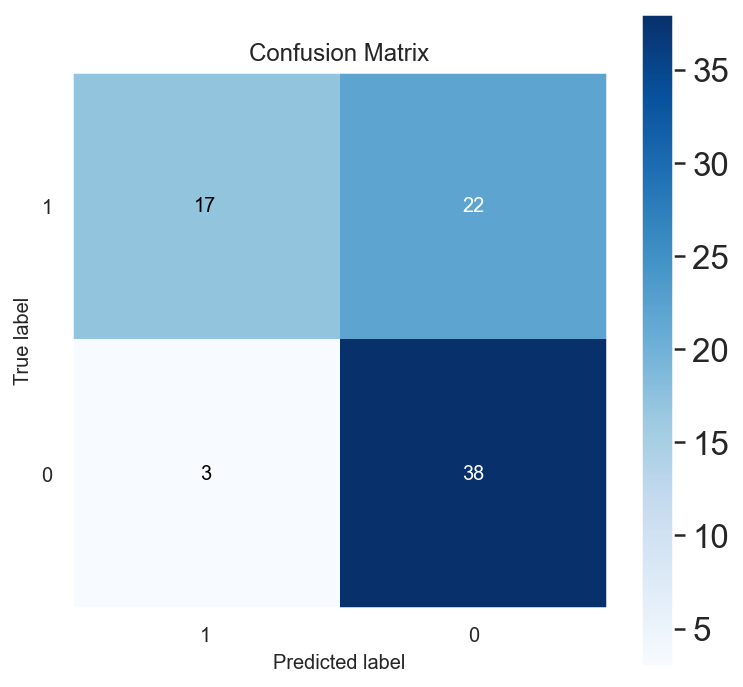

In [ ]:
print(classification_report(y_test, prob_test['prediction']))

#              precision    recall  f1-score   support

#            0       0.63      0.93      0.75        41
#            1       0.85      0.44      0.58        39

#     accuracy                           0.69        80
#    macro avg       0.74      0.68      0.66        80
# weighted avg       0.74      0.69      0.67        80


In [ ]:
probabilities_test_rf = gs_rf.best_estimator_.predict_proba(X_test)

skplt.metrics.plot_precision_recall(y_test, probabilities_test_rf)
plt.show()

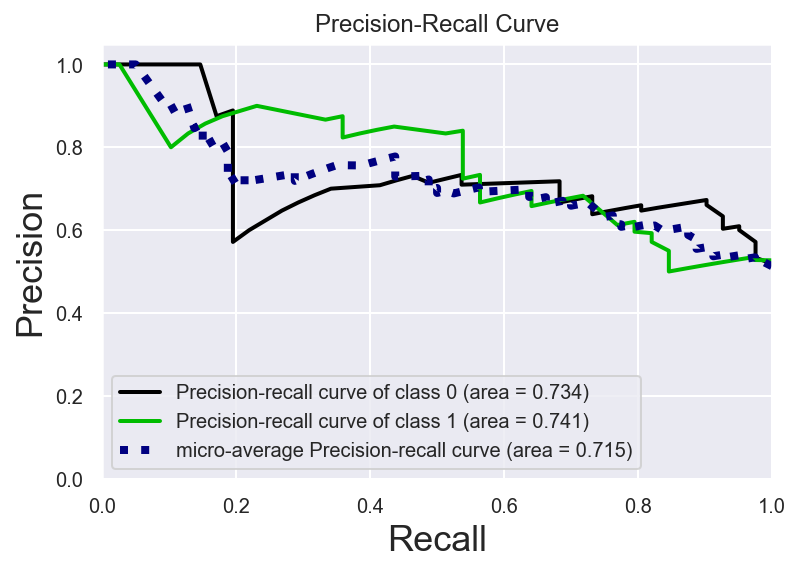

In [ ]:
probabilities_test_rf = gs_rf.best_estimator_.predict_proba(X_test)skplt.metrics.plot_roc(y_test, probabilities_test_rf)
plt.show()

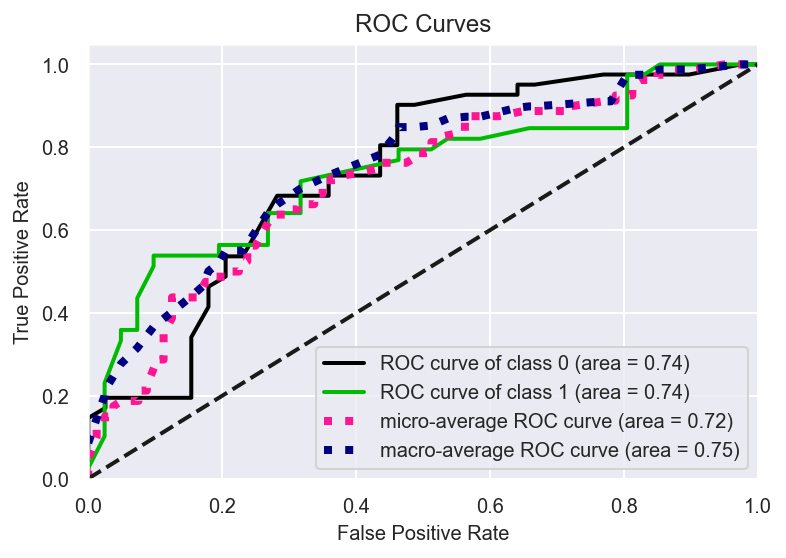

#### Conclusions
The highest performing model was able to predict new data accurately around 70% of the time. This is a significant improvement from the baseline, which stood at 50%. The baseline of 50% is given by the majority class within the data. In this case, being 50.7% of the data categorized as low salaries, then guessing low salary on all the data would be our baseline.
Additionally, we are able to identify which factors are the most important for identifying high or low salaries, e.g.: whether the job is in London or in a small city and whether the job title refers to a manager, lead or engineer.
A consideration must be made due to the really low number of observations compared to the total of job results scraped from Indeed. Only few companies decide to advertise a salary estimate, therefore it cannot be guaranteed that the salaries extracted truly represent the general job market. Also, the job market in the Data Science field is in rapid evolution and the boundaries between different job positions are not well defined. Moreover, additional data could be taken in consideration, such as extracting information from job descriptions, to increase the performance of the models. Lastly, the tradeoff between model accuracy and minimization of false positives should be kept in mind when evaluating the results.